In [1]:
import os 
import matplotlib.pyplot as plt 
from scipy.io.wavfile import read
import time 


In [2]:
#%reload_ext autoreload

#%autoreload
class Yin(object):
    
    def __init__(self, bufferSize, fs, threshold = 0.1):
        self.buffer_size = bufferSize
        self.half_buffer_size = int(bufferSize / 2)
        self.rate = fs
        self.yin_buffer = int(bufferSize/2)*[0.0]
        self.probability = 0.0 
        self.threshold = threshold 
    
    
    def runit(self, audio):
        start = time.time()
        i = 0 
        pitch = 0 

        while pitch < 10:
         
            pitch = yin.get_pitch(audio)
            #self.update_buffer_size()
            i += 1
            print (i)
         
        t = time.time() - start
        print('found : '+ str(pitch) + ' after ' + str(i) + ' in ' + str(t) + 's')
    
        
        
    def update_buffer_size(self):
        self.buffer_size += 1
        self.half_buffer_size = int(self.buffer_size/2)
        self.yin_buffer.append(0)
        
              
    # Pitch detection algorithm    
    def get_pitch(self, buffer):
        buffer = buffer.copy()
        pitch_Hz = 1
        
        # step 1: calculate squared difference of signal with a shifted version of itself
        self.difference(buffer)
        
        
        # step 2: calculate cumulative mean on normalized difference calculations in step 1
        self.cumulative_mean_normalized_difference()
        
        # step 3: search and find values over theshold through normalized cumulative mean array 
        tau_estimate = self.absolute_threshold()
        print("tau" + str(tau_estimate))
        
        if tau_estimate != -1:
            val = self.parabolic_interpolation(tau_estimate)
            pitch_Hz = self.rate / val
     
        return pitch_Hz
    
    
    
    def get_probability(self):
        return self.probability 
    
    
    def difference(self, buffer):
        
        # calculate difference for difference shift values (tau) for half the samples
    
        for tau in range (0, self.half_buffer_size):
            # difference of signal with shifted version of itself
            # tweak on autocorrelation
            for i in range(0, self.half_buffer_size):
                
                delta = buffer[i] - buffer[i + tau]
                self.yin_buffer[tau] += delta * delta
                
            
        #x = np.arange(0,self.half_buffer_size)
        #plt.plot(x, self.yin_buffer)
        #plt.show()
                

    # calculate cumulative mean on normalized difference calculated in step 1
    def cumulative_mean_normalized_difference(self):
        running_sum = 0 
        self.yin_buffer[0] = 1
        
        # sum all values in autocorrelation buffer and normalize the result,
        # replacing the value in autocorrelation buffer w/ cumulative mean of normalized difference 
        
        for tau in range (1, self.half_buffer_size):
            running_sum += self.yin_buffer[tau]
            self.yin_buffer[tau] *= tau / running_sum 
            
        
        x = np.arange(0,self.half_buffer_size)
        plt.plot(x, self.yin_buffer)
        plt.show()
                
            
    def absolute_threshold(self):
        # sesarch array of cumulative mean values. Look for ones over threhold
        # first two positions are always largest, so start at the third
        for tau in range(2,self.half_buffer_size):
            if (self.yin_buffer[tau] < self.threshold):
                while(tau + 1 < self.half_buffer_size and self.yin_buffer[tau+ 1] < self.yin_buffer[tau]):
                    tau += 1
                    
                # exit loop when tau is found 
                # self.threshold determines candadates admitted to set 
                # "proportion of aperiodic power tolerated within a periodic signal 
                
                # want periodicity, not aperiodicity
                self.probability = 1 - self.yin_buffer[tau]
                break
            
        if (tau == self.half_buffer_size or self.yin_buffer[tau] >= self.threshold):
            # if pitch not found, return -1       
            self.probability = 0 
            tau = -1
        
        return tau
    
    #interpolate shift value to improve pitch estimation 
    # best shift value is most likely not an integer shift of the signal. 
    # Check that there isnt a better fractional shift value 
    def parabolic_interpolation(self, tau_estimate):
        
        # calculate first polynomial coefficient based on current estimate of tau 
        if tau_estimate < 1: 
            x0 = tau_estimate
        else:
            x0 = tau_estimate - 1
        
        # calculate second polynoimal coefficient based on current estimate 
        if tau_estimate + 1 < self.half_buffer_size: 
            x2 = tau_estimate + 1
        else: 
            x2 = tau_estimate 
            
        # parabolic interpolating shift value tau 
        if x0 == tau_estimate: 
            if self.yin_buffer[tau_estimate] <= self.yin_buffer[x2]:
                better_tau = tau_estimate
            else:
                better_tau = x2
                
        elif x2 == tau_estimate:
            if self.yin_buffer[tau_estimate] <= self.yin_buffer[x0]:
                better_tau = tau_estimate
                
            else:
                better_tau = x0
                
        else:
            s0 = self.yin_buffer[x0]
            s1 = self.yin_buffer[tau_estimate]
            s2 = self.yin_buffer[x2]
            
            better_tau = tau_estimate + (s2 - s0) / (2 * (2 * s1 - s2 - s0))
            
        return better_tau

In [3]:
import wave 
import pyaudio
import numpy as np 
import threading 

class Listener(object):
    """
    The Listener  class is made to provide access to continuously recorded
    (and mathematically processed) microphone data.
    """

    def __init__(self,algorithm,chunk,rate,device=None,startStreaming=True, ):
      
        print(" -- initializing Listener")
        
        self.algorithm = algorithm
        self.chunk = chunk # number of data points to read at a time
        self.rate = rate # time resolution of the recording device (Hz)

        # for tape recording (continuous "tape" of recent audio)
        self.tapeLength=2 #seconds
        self.tape = np.zeros(self.rate*self.tapeLength)
        self.record = []
        
        self.p=pyaudio.PyAudio() # start the PyAudio class
        if startStreaming:
            self.stream_start()

    ### LOWEST LEVEL AUDIO ACCESS
    # pure access to microphone and stream operations
    # keep math, plotting, FFT, etc out of here.
    
    def stream_read(self):
        """return values for a single chunk"""
        audio_in = self.stream.read(self.chunk, exception_on_overflow = False)
        self.record.append(audio_in)
        data = np.fromstring(audio_in, dtype=np.int16)
        return data

    def stream_start(self):
        """connect to the audio device and start a stream"""
        print(" -- stream started")
        self.stream=self.p.open(format=pyaudio.paInt16,channels=1,
                                rate=self.rate,input=True,
                                frames_per_buffer=self.chunk)
                                #input_device_index = 0)

    def stream_stop(self):
        """close the stream but keep the PyAudio instance alive."""
        #if 'stream' in locals():
        self.stream.stop_stream()
        self.stream.close()
        print(" -- stream CLOSED")
        

    def close(self):
        """gently detach from things."""
        self.stream_stop()
        self.p.terminate()

    ### TAPE METHODS
    # tape is like a circular magnetic ribbon of tape that's continously
    # recorded and recorded over in a loop. self.tape contains this data.
    # the newest data is always at the end. Don't modify data on the type,
    # but rather do math on it (like FFT) as you read from it.

    def tape_add(self):
        """add a single chunk to the tape."""
        while True:

            self.tape[:-self.chunk]=self.tape[self.chunk:]
            self.tape[-self.chunk:]=self.stream_read()
            
            
            
    def tape_flush(self):
        """completely fill tape with new data."""
        readsInTape=int(self.rate*self.tapeLength/self.chunk)
        print(" -- flushing %d s tape with %dx%.2f ms reads"%\
                  (self.tapeLength,readsInTape,self.chunk/self.rate))
        for i in range(readsInTape):
            self.tape_add()

    def tape_plot(self,saveAs="03.png"):
        """plot what's in the tape."""
        pylab.plot(np.arange(len(self.tape))/self.rate,self.tape)
        pylab.axis([0,self.tapeLength,-2**16/2,2**16/2])
        pylab.show()
        print() #good for IPython
        #pylab.close('all')
        
    
        
    def realtime_analysis(self,duration = 10,  plotSec=.25):
        t1=0
       
        #try:
        #while True:
        
        th = threading.Thread (target = self.tape_add)
        th.start()
        
        time.sleep(1)
        
        for i in range(0, int(self.rate / self.chunk * duration)):
            self.algorithm.runit(self.tape[:-(3*self.chunk):-1])

             
#         except:
#             print(" ~~ exception (keyboard?)")


        return

    def export_wav(self, filename, rate):
            
        # output recorded 
        waveFile = wave.open(filename, 'wb')
        waveFile.setnchannels(1)
        waveFile.setsampwidth(audio_port.p.get_sample_size(pyaudio.paInt16))
        waveFile.setframerate(rate)
        waveFile.writeframes(b''.join(audio_port.record))
        waveFile.close()
            


 -- initializing Listener
 -- stream started


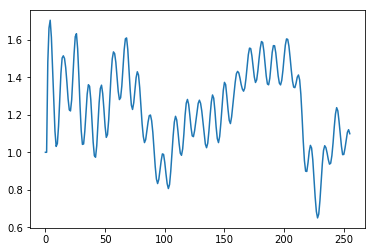

tau-1
1


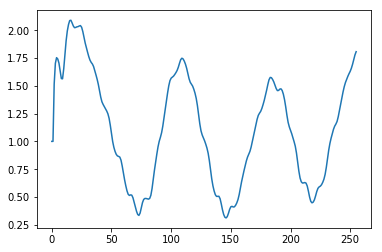

tau-1
2


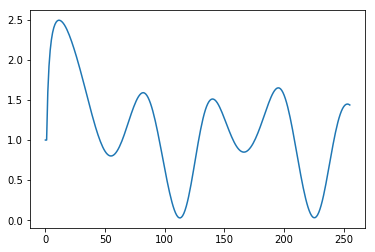

tau113
3
found : 142.052037996 after 3 in 0.5490753650665283s


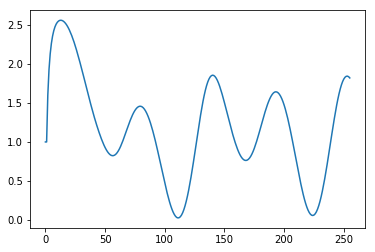

tau111
1
found : 143.891196039 after 1 in 0.1646571159362793s


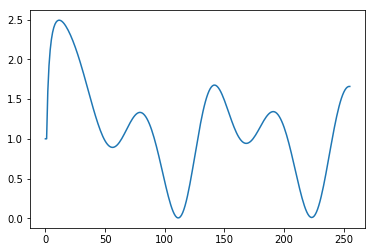

tau111
1
found : 143.789517384 after 1 in 0.16392993927001953s


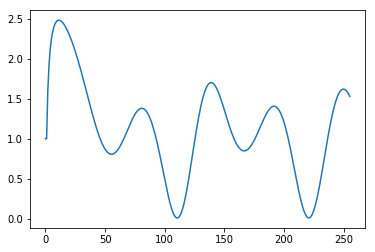

tau110
1
found : 144.86091835 after 1 in 0.16869497299194336s


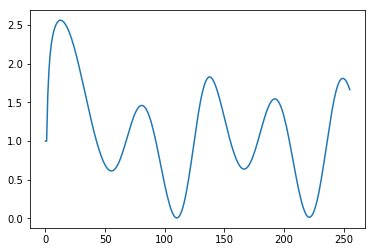

tau110
1
found : 145.344716617 after 1 in 0.18977093696594238s


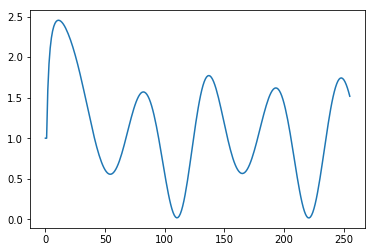

tau110
1
found : 145.129966216 after 1 in 0.15984892845153809s


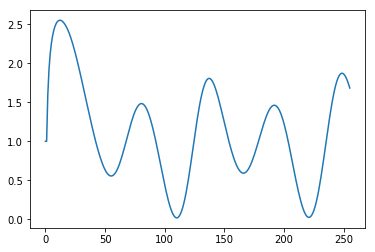

tau110
1
found : 145.441545833 after 1 in 0.16320586204528809s


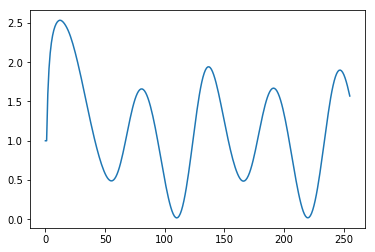

tau110
1
found : 145.424432339 after 1 in 0.1669447422027588s


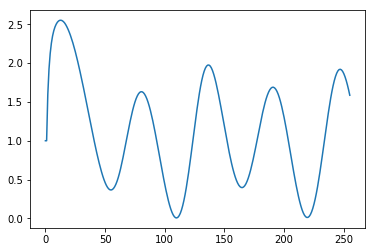

tau110
1
found : 145.767044921 after 1 in 0.15595388412475586s


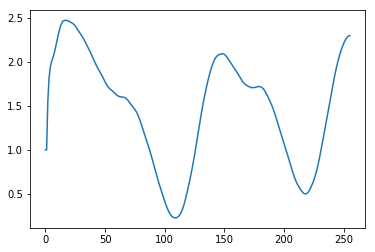

tau-1
1


KeyboardInterrupt: 

In [4]:

%reload_ext autoreload

if __name__ =="__main__":
    
    %autoreload
    buffer_len = 512
    pitch = 0 
    fs = 16000
    yin = Yin(buffer_len, fs)
    chunk = 512
    
    # listener init 
    audio_port = Listener(yin, chunk, fs)

    # listen and analyze 
    audio_port.realtime_analysis()
    
    audio_port.export_wav("Test.wav", fs)
    audio_port.close()

